In [1]:
import os

In [2]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting'

[2024-09-23 22:47:46,868: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-09-23 22:47:46,885: INFO: common: yaml file: params.yaml loaded successfully]
[2024-09-23 22:47:46,887: INFO: common: created directory at: artifacts]
[2024-09-23 22:47:46,889: INFO: common: created directory at: artifacts/data_transformation]
[2024-09-23 22:47:46,898: INFO: 942555749: Data loaded from artifacts\data_ingestion\Sandblasting-Condition.csv]
[2024-09-23 22:47:46,906: INFO: 942555749: Data Head: 
   angle_sandblasting  pressure_sandblasting_bar  temperature_acid_etching  \
0                  30                          3                        25   
1                  40                          3                        25   
2                  50                          3                        25   
3                  30                          3                        25   
4                  30                          3                        25   

   time_acid_etching_m

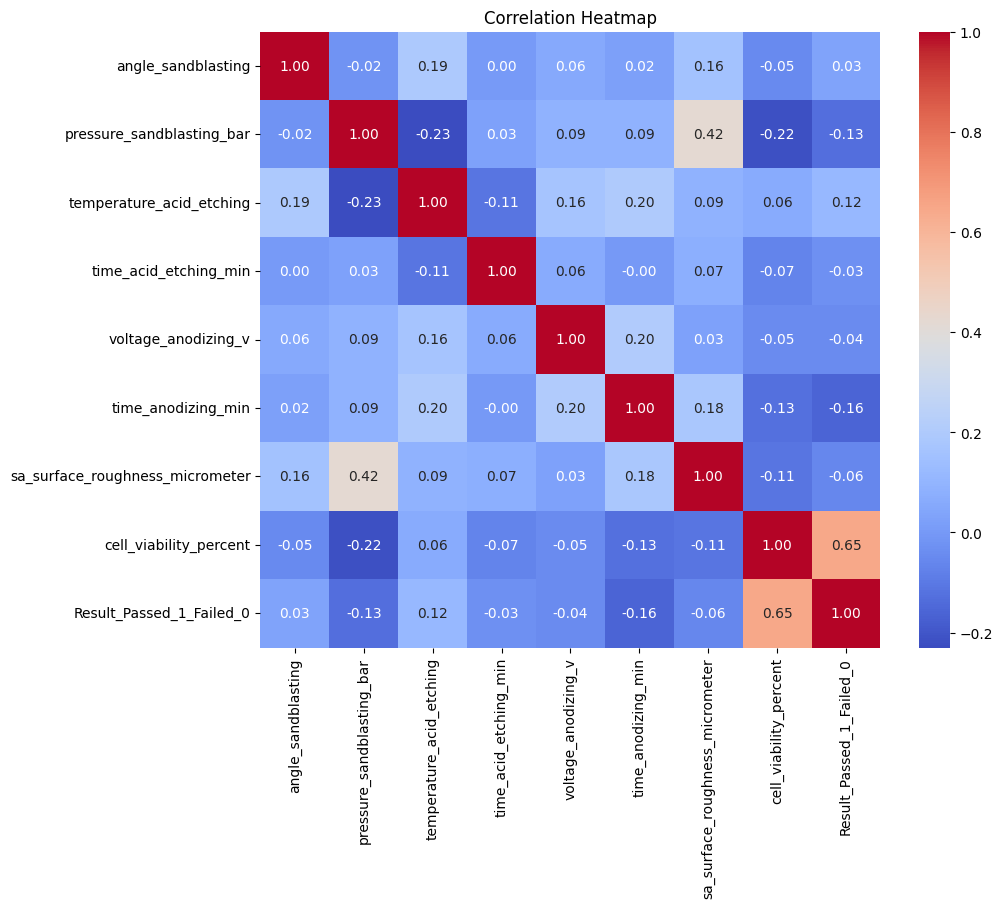

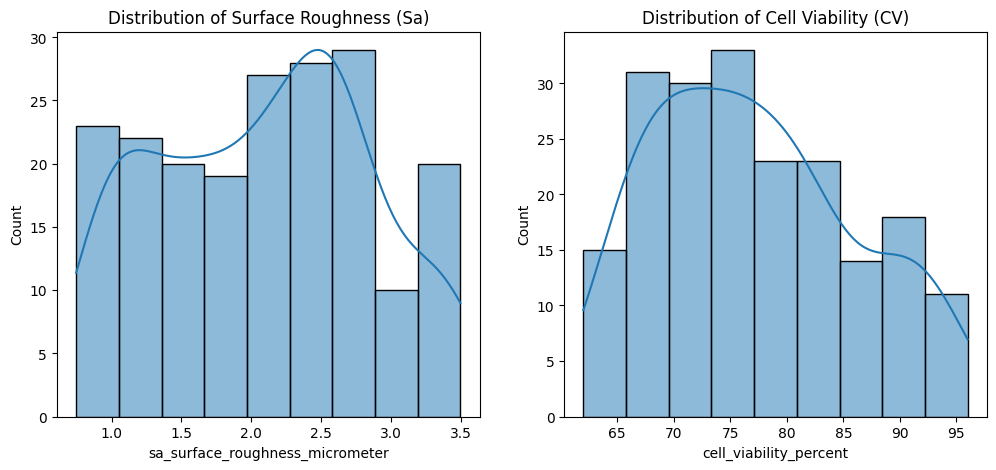

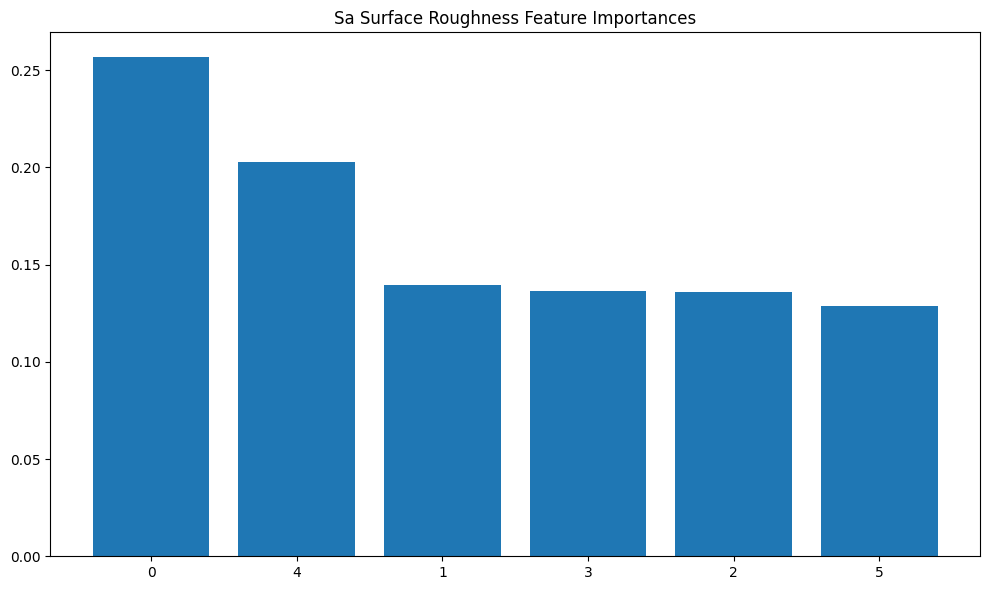

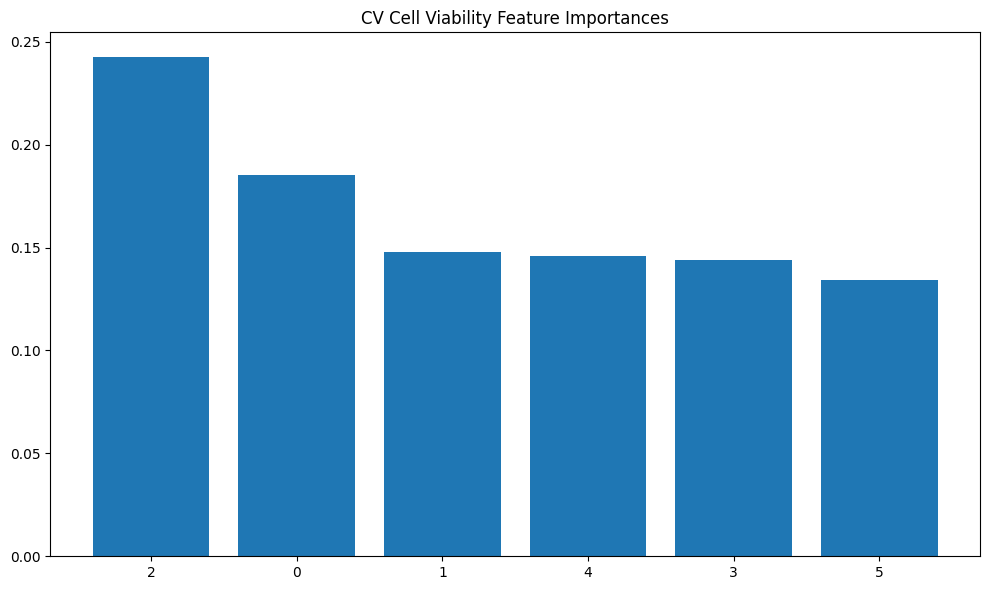

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from pathlib import Path
import os
from dataclasses import dataclass
from Dental_Implant_Sandblasting import logger
from Dental_Implant_Sandblasting.utils.common import read_yaml, create_directories
from Dental_Implant_Sandblasting.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH, SCHEMA_FILE_PATH

# Data class for Data Transformation configuration
@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path
    transformed_train_dir: Path
    transformed_test_dir: Path
    test_size: float
    random_state: int
    polynomial_features_degree: int
    scaling_method: str
    lasso_max_iter: int
    knn_n_neighbors: int

# Configuration Manager class for loading configurations
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH, schema_filepath=SCHEMA_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config['artifacts_root']])

    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config['data_transformation']
        params = self.params['data_transformation']
        create_directories([config['root_dir']])
        data_transformation_config = DataTransformationConfig(
            root_dir=Path(config['root_dir']),
            data_path=Path(config['data_path']),
            transformed_train_dir=Path(config['transformed_train_path']),
            transformed_test_dir=Path(config['transformed_test_path']),
            test_size=params['test_size'],
            random_state=params['random_state'],
            polynomial_features_degree=params['polynomial_features_degree'],
            scaling_method=params['scaling_method'],
            lasso_max_iter=params['lasso_max_iter'],
            knn_n_neighbors=params['knn_n_neighbors']
        )
        return data_transformation_config

# Data Transformation class
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config

    def load_data(self):
        data = pd.read_csv(self.config.data_path)
        logger.info(f"Data loaded from {self.config.data_path}")

        # Basic Data Exploration
        logger.info(f"Data Head: \n{data.head()}")
        logger.info(f"Data Info: \n{data.info()}")
        logger.info(f"Data Description: \n{data.describe()}")

        return data

    def preprocess_data(self, data):
        # Convert columns to numeric, forcing any errors to NaN
        for col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

        # Use KNN Imputer to handle missing values
        imputer = KNNImputer(n_neighbors=self.config.knn_n_neighbors)
        data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

        logger.info("Missing values handled using KNN imputation")
        return data_imputed

    def feature_engineering(self, data):
        # Define feature and target columns
        feature_columns = [
            'angle_sandblasting',
            'pressure_sandblasting_bar',
            'temperature_acid_etching',
            'time_acid_etching_min',
            'voltage_anodizing_v',
            'time_anodizing_min'
        ]
        target_column_sa = 'sa_surface_roughness_micrometer'
        target_column_cv = 'cell_viability_percent'

        X = data[feature_columns]
        y_sa = data[target_column_sa]
        y_cv = data[target_column_cv]

        # Apply PolynomialFeatures
        poly = PolynomialFeatures(degree=self.config.polynomial_features_degree, include_bias=False)
        X_poly = poly.fit_transform(X)

        # Standardize the features using RobustScaler
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X_poly)

        # Apply PCA for dimensionality reduction
        pca = PCA(n_components=0.95)
        X_pca = pca.fit_transform(X_scaled)
        logger.info(f"Number of components after PCA: {X_pca.shape[1]}")

        # Feature Selection using RFE with Lasso
        lasso_model = Lasso(alpha=0.01, max_iter=self.config.lasso_max_iter)

        rfe_sa = RFE(lasso_model, n_features_to_select=10)
        X_sa_rfe = rfe_sa.fit_transform(X_pca, y_sa)

        rfe_cv = RFE(lasso_model, n_features_to_select=10)
        X_cv_rfe = rfe_cv.fit_transform(X_pca, y_cv)

        logger.info(f"Number of features selected for Sa after RFE: {X_sa_rfe.shape[1]}")
        logger.info(f"Number of features selected for CV after RFE: {X_cv_rfe.shape[1]}")

        return X_sa_rfe, X_cv_rfe, y_sa, y_cv

    def train_test_splitting(self, X_sa_rfe, X_cv_rfe, y_sa, y_cv):
        # Split the data into training and testing sets for Surface Roughness (Sa) and Cell Viability (CV)
        X_train_sa, X_test_sa, y_sa_train, y_sa_test = train_test_split(X_sa_rfe, y_sa, test_size=self.config.test_size, random_state=self.config.random_state)
        X_train_cv, X_test_cv, y_cv_train, y_cv_test = train_test_split(X_cv_rfe, y_cv, test_size=self.config.test_size, random_state=self.config.random_state)

        # Ensure directories exist before saving the files
        os.makedirs(self.config.transformed_train_dir, exist_ok=True)
        os.makedirs(self.config.transformed_test_dir, exist_ok=True)

        # Save the transformed datasets with consistent naming conventions
        train_data_sa = pd.DataFrame(X_train_sa)
        train_data_cv = pd.DataFrame(X_train_cv)
        train_data_sa.to_csv(self.config.transformed_train_dir / 'train_sa_target.csv', index=False)
        train_data_cv.to_csv(self.config.transformed_train_dir / 'train_cv_target.csv', index=False)
        logger.info(f"Training data saved: Sa - {train_data_sa.shape}, CV - {train_data_cv.shape}")

        test_data_sa = pd.DataFrame(X_test_sa)
        test_data_cv = pd.DataFrame(X_test_cv)
        test_data_sa.to_csv(self.config.transformed_test_dir / 'test_sa_target.csv', index=False)
        test_data_cv.to_csv(self.config.transformed_test_dir / 'test_cv_target.csv', index=False)
        logger.info(f"Testing data saved: Sa - {test_data_sa.shape}, CV - {test_data_cv.shape}")

    def execute(self):
        try:
            data = self.load_data()
            preprocessed_data = self.preprocess_data(data)
            X_sa_rfe, X_cv_rfe, y_sa, y_cv = self.feature_engineering(preprocessed_data)
            self.train_test_splitting(X_sa_rfe, X_cv_rfe, y_sa, y_cv)

            # Create status file
            with open(self.config.root_dir / "status.txt", "w") as f:
                f.write("Transformation status: True")

            logger.info("Data transformation and splitting completed successfully.")

            # Visualizations
            self.visualizations(preprocessed_data, X_sa_rfe, X_cv_rfe, y_sa, y_cv)

        except Exception as e:
            # Create status file with failure status
            with open(self.config.root_dir / "status.txt", "w") as f:
                f.write("Transformation status: False")

            logger.exception(e)
            raise e

    # Visualizations Section
    def visualizations(self, preprocessed_data, X_sa_rfe, X_cv_rfe, y_sa, y_cv):
        # # Visualizations 
        # Correlation Heatmap for the dataset
        plt.figure(figsize=(10, 8))
        sns.heatmap(preprocessed_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title("Correlation Heatmap")
        plt.show()

        # Distribution of Target Variables
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(y_sa, kde=True)
        plt.title('Distribution of Surface Roughness (Sa)')
        plt.subplot(1, 2, 2)
        sns.histplot(y_cv, kde=True)
        plt.title('Distribution of Cell Viability (CV)')
        plt.show()

        # # Plotting Feature Importances for Sa
        self.plot_feature_importances(X_sa_rfe, y_sa, "Sa Surface Roughness Feature Importances")

        # # Plotting Feature Importances for CV
        self.plot_feature_importances(X_cv_rfe, y_cv, "CV Cell Viability Feature Importances")

    # Plot Feature Importances using RandomForest
    def plot_feature_importances(self, X, y, title):
        model = RandomForestRegressor()
        model.fit(X, y)
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot the feature importances
        plt.figure(figsize=(10, 6))
        plt.title(title)
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), indices)
        plt.tight_layout()
        plt.show()

# Pipeline execution
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = DataTransformation(config=data_transformation_config)
    data_transformation.execute()
except Exception as e:
    logger.exception(e)
    raise e
